In [245]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
from scipy.special import factorial2
from scipy.interpolate import splrep, splev
from scipy.special import comb
from numpy.polynomial.hermite import hermgauss
from py_vollib.black_scholes.implied_volatility import implied_volatility
vec_find_vol_rat = np.vectorize(implied_volatility)   #imp vol estimator based on P Jäckel Let's be rational
from py_vollib.black_scholes.implied_volatility import implied_volatility as bs_iv
import scipy.interpolate
import scipy.special


In [246]:
def simulate_OU(lambda0, T, n_steps, N_sims, w):
    """
    Simulates an Ornstein-Uhlenbeck process with mean-reversion rate lambda0.
    
    Parameters:
        lambda0 : float
            Mean-reversion speed
        T : float
            Total time
        n_steps : int
            Number of time steps
        N_sims : int
            Number of simulations (default 1)
        w : ndarray of shape (n_steps, N_sims)
            Standard normal increments (pre-generated)

    Returns:
        times : ndarray of shape (n_steps + 1,)
            Time grid
        X : ndarray of shape (n_steps + 1, N_sims)
            Simulated OU paths
    """
    dt = T / n_steps
    times = np.linspace(0, T, n_steps + 1)
    X = np.zeros((n_steps + 1, N_sims))

    exp_fac = np.exp(-lambda0 * dt)
    var_fac = np.sqrt((1 - np.exp(-2 * lambda0 * dt)) / (2 * lambda0))

    for i in range(n_steps):
        X[i + 1, :] = exp_fac * X[i, :] + var_fac * w[i, :]

    return times, X


In [247]:
def generate_Z(X,Y,theta):
    return theta*X+(1-theta)*Y

def sigma_squared_G(t, s, theta, lambda_x, lambda_y):
    dt = s - t  # assumes s > t
    term1 = (theta**2 / (2 * lambda_x)) * (1 - np.exp(-2 * lambda_x * dt))
    term2 = ((1 - theta)**2 / (2 * lambda_y)) * (1 - np.exp(-2 * lambda_y * dt))
    term3 = (2 * theta * (1 - theta) / (lambda_x + lambda_y)) * (1 - np.exp(-(lambda_x + lambda_y) * dt))
    return term1 + term2 + term3


In [248]:
def vix_future_price_mc(T, Z_mc, theta, lambda_x, lambda_y, p_k,
                        T_nodes, int_var_nodes,
                        co_var_func, gaussian_moments,
                        tt_gs, w_t_gs):
    """
    Compute the VIX future price using Monte Carlo under a 2-factor model.
    
    Parameters:
    - T: float, maturity
    - Z_mc: array (2, N), Gaussian samples
    - theta, lambda_x, lambda_y: model parameters
    - p_k: array, polynomial coefficients of f(x)
    - T_nodes, int_var_nodes: arrays for forward variance curve
    - co_var_func(theta_val, lambda_x, lambda_y, t, cross=False): callable
    - gaussian_moments(std, deg): callable, returns moment of Gaussian
    - tt_gs, w_t_gs: quadrature nodes and weights (over [-1, 1])
    
    Returns:
    - Ft: float, VIX future price (in percentage units)
    """
    delt = 30 / 360
    T_delta = T + delt
    n = len(p_k)

    # Rescale Gauss-Legendre points to [T, T+delta]
    tt = 0.5 * (tt_gs + 1) * (T_delta - T) + T
    w_tt = w_t_gs / 2 * (T_delta - T)

    # Interpolate xi_0
    spline = scipy.interpolate.splrep(T_nodes, int_var_nodes, k=3)
    xi_0_t = scipy.interpolate.splev(tt, spline, der=1)
    xi_0_t = np.sqrt(xi_0_t**2)

    # Compute std_Z_t and normalization constant
    std_Z_t = np.sqrt(co_var_func(theta, lambda_x, lambda_y, tt))
    cauchy_product = np.convolve(p_k, p_k)
    even_indices = np.arange(0, 2*n, 2).reshape(-1, 1)
    normalizer = np.sum(
        cauchy_product[even_indices] *
        std_Z_t**even_indices *
        np.maximum(scipy.special.factorial2(even_indices - 1), 1),
        axis=0
    )
    g_0_s_squared = xi_0_t / normalizer

    # Compute G_s^t moments
    std_G_s_t = np.sqrt(co_var_func(theta, lambda_x, lambda_y, tt - T))
    mmt_G_s_t = np.array([gaussian_moments(std_G_s_t, k) for k in range(2*n - 1)])
    combinatory_matrix = scipy.special.comb(np.arange(2*n - 1), np.arange(2*n - 1).reshape(-1, 1))

    # Simulate (X_T, Y_T)
    var_X = co_var_func(1, lambda_x, lambda_y, T)
    var_Y = co_var_func(0.0, lambda_x, lambda_y, T)
    covar_XY = co_var_func(0.5, lambda_x, lambda_y, T, cross=True)
    corr = covar_XY / np.sqrt(var_X * var_Y)

    X = Z_mc[0:1].T * np.sqrt(var_X)
    Y = (corr * Z_mc[0:1].T + np.sqrt(1 - corr**2) * Z_mc[1:2].T) * np.sqrt(var_Y)

    # Compute VIX_T^2
    X_power = X**np.arange(0, 2*n - 1)[np.newaxis]
    Y_power = Y**np.arange(0, 2*n - 1)[np.newaxis]
    l_array = np.arange(0, 2*n - 1)
    vix_T_squared = 0.0

    for m in range(2*n - 1):
        for l in range(m, 2*n - 1):
            k_array = np.arange(l, 2*n - 1)
            decay = np.exp(-(m * lambda_x + (l - m) * lambda_y) * (tt - T))
            integral = np.sum((mmt_G_s_t[k_array - l] * decay * g_0_s_squared) * w_tt, axis=1)
            beta_m_l = np.sum(
                cauchy_product[k_array] * integral * combinatory_matrix[l, l:]
            ) * combinatory_matrix[m, l] * theta**m * (1 - theta)**(l - m)

            vix_T_squared += np.sum(X_power[:, m:m+1] * Y_power[:, l_array[m:] - m] * beta_m_l, axis=1)

    vix_T_squared /= delt
    vix_T = np.sqrt(vix_T_squared)
    Ft = np.mean(vix_T)
    return Ft * 100  # return in percentage units


In [249]:
def expected_f_squared(p_k, std_X_t):
    p_k = np.asarray(p_k)
    std_X_t = np.asarray(std_X_t)
    n = len(p_k)
    even_indices = np.arange(0, 2 * n, 2)
    cauchy_product = np.convolve(p_k, p_k)
    std_powers = std_X_t[np.newaxis, :] ** even_indices[:, np.newaxis]
    double_fac = np.maximum(factorial2(even_indices - 1)[:, np.newaxis], 1)
    E_fx_squared = np.sum(
        cauchy_product[even_indices][:, np.newaxis] * std_powers * double_fac,
        axis=0
    )
    return E_fx_squared


In [250]:
import numpy as np
from scipy import interpolate
from scipy.special import factorial2


def horner_vector(p, n, x):
    result = np.zeros_like(x)
    for i in range(n):
        result = result * x + p[i]
    return result
def evaluate_volatility_process(p_k, X_t, std_X_t, T_nodes, int_var_nodes):
    T, N = X_t.shape
    p_k = np.asarray(p_k)
    n = len(p_k)
    even_indices = np.arange(0, 2 * n, 2)
    cauchy_product = np.convolve(p_k, p_k)
    std_powers = std_X_t[np.newaxis, :] ** even_indices[:, np.newaxis]
    double_fac = np.maximum(factorial2(even_indices - 1)[:, np.newaxis], 1)
    normal_var = np.sum(
        cauchy_product[even_indices][:, np.newaxis] * std_powers * double_fac,
        axis=0
    )
    f_X = horner_vector(p_k[::-1], n, X_t)
    inter_var_spline = interpolate.splrep(T_nodes, int_var_nodes, k=3)
    xi_0_t = interpolate.splev(np.linspace(T_nodes[0], T_nodes[-1], T), inter_var_spline, der=1)
    xi_0_t = np.maximum(xi_0_t, 1e-10).reshape(-1, 1)
    volatility = np.sqrt(xi_0_t) * f_X / np.sqrt(normal_var).reshape(-1, 1)
    return volatility

In [251]:
import numpy as np
from scipy import interpolate
from scipy.special import factorial2





def simulate_log_asset_price(S0, rho, dt, X_t, std_X_t, p_k, T_nodes, int_var_nodes, w1):
    """
    Simulate log S_T using a stochastic volatility model driven by polynomial f(X_t)

    Parameters
    ----------
    S0 : float
        Initial asset price
    rho : float
        Correlation between asset and volatility drivers
    dt : float
        Time step size
    X_t : ndarray, shape (T, N)
        Simulated process driving volatility
    std_X_t : ndarray, shape (T,)
        Standard deviation of X_t at each time t
    p_k : array_like
        Polynomial coefficients for volatility model
    T_nodes, int_var_nodes : arrays
        Spline definition of forward variance curve ∫₀ᵗ ξ₀(s) ds
    w1 : ndarray, shape (T, N)
        Brownian increments

    Returns
    -------
    log_S_T : ndarray, shape (N,)
        Final log-asset prices at maturity T
    """
    volatility = evaluate_volatility_process(p_k, X_t, std_X_t, T_nodes, int_var_nodes)  # (T, N)
    logS = np.log(S0) * np.ones(w1.shape[1])  # shape (N,)

    for i in range(w1.shape[0]):
        vol = volatility[i]
        dW = w1[i]
        logS = logS - 0.5 * rho**2 * vol**2 * dt + rho * vol * np.sqrt(dt) * dW

    return logS


In [252]:
T = 1.0
n_steps = 100
dt = T / n_steps
N = 10000
tt = np.linspace(0, T, n_steps + 1)

# Simulate X_t ~ OU or BM (example)
X_t = np.random.normal(0, 1, size=(n_steps, N))
std_X_t = np.std(X_t, axis=1)

# Polynomial: f(x) = 1 + 0.2 x^2
p_k = [1.0, 0.0, 0.2]

# Flat forward variance: ξ₀(t) = 0.04
T_nodes = np.linspace(0, T, 10)
int_var_nodes = 0.04 * T_nodes  # ξ₀(t) ≈ d/dt ∫₀ᵗ ξ₀(s) ds = 0.04

# Brownian increments
w1 = np.random.normal(0, 1, size=(n_steps, N))

# Simulate log S_T
log_S_T = simulate_log_asset_price(100.0, rho=0.7, dt=dt, X_t=X_t, std_X_t=std_X_t,
                                    p_k=p_k, T_nodes=T_nodes, int_var_nodes=int_var_nodes, w1=w1)

S_T = np.exp(log_S_T)


In [253]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:

import numpy as np
import scipy


from py_vollib.black_scholes.implied_volatility import implied_volatility

def vec_find_iv_rat(opt_price, S, K, t, r, flag):
    return np.vectorize(implied_volatility)(opt_price, S, K, t, r, flag)


def horner_vector(poly, n, x):
    """
    Evaluate a polynomial at x using Horner's method, vectorized over x.

    Parameters
    ----------
    poly : list or array-like
        Polynomial coefficients [a_0, a_1, ..., a_n] for a_0 + a_1 x + ... + a_n x^n.

    n : int
        Degree + 1 (i.e., number of coefficients)

    x : ndarray of shape (time, N_sims)
        Points where the polynomial should be evaluated

    Returns
    -------
    result : ndarray of shape (time, N_sims)
        Evaluated polynomial values at each x
    """
    result = poly[0] * np.ones_like(x)
    for i in range(1, n):
        result = result * x + poly[i]
    return result
def bs_price_call(s, sigma, T, K):
    """
    Compute Black-Scholes call option prices.

    Parameters
    ----------
    s : ndarray of shape (N_sims, 1)
        Simulated terminal prices.
    sigma : ndarray of shape (N_sims, 1)
        Standard deviations (volatilities).
    T : float
        Time to maturity.
    K : ndarray of shape (1, N_strikes)
        Strike prices.

    Returns
    -------
    prices : ndarray of shape (N_sims, N_strikes)
        Call option prices for each simulation and strike.
    """
    s = s.reshape(-1, 1)        # (N_sims, 1)
    sigma = sigma.reshape(-1, 1)  # (N_sims, 1)
    K = K.reshape(1, -1)        # (1, N_strikes)

    d1 = (np.log(s / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    price = s * scipy.special.ndtr(d1) - K * scipy.special.ndtr(d2)
    return price



# In[ ]:

In [254]:
def std_X_t(theta,lamda_x,lamda_y,tt):
    var_X = (
            theta**2 / (2 * lamda_x) * (1 - np.exp(-2 * lamda_x * tt))
            + (1-theta)**2 / (2 * lamda_y) * (1 - np.exp(-2 * lamda_y * tt))
            + 2
            * theta*(1-theta)
            / (lamda_x + lamda_y)
            * (1 - np.exp(-(lamda_x + lamda_y) * tt))
        )
    std_X_t = np.sqrt(var_X)
    return std_X_t

def volatility(std_X_t, X_t, a_k, T_nodes, int_var_nodes, tt):
    """
    Compute model volatility given std_X_t and X_t.

    Parameters:
        std_X_t: (n_steps+1, N_sims)
        X_t:     (n_steps+1, N_sims)
        a_k:     coefficients of f(x)
        T_nodes, int_var_nodes: spline nodes for xi_0(t)
        tt: time grid (shape: n_steps+1,)
    """
    n = len(a_k)
    even_indices = np.arange(0, 2 * n, 2)  # 0, 2, 4, ...
    cauchy_product = np.convolve(a_k, a_k)
    
    # Compute std_X_t ** k for all even k
    std_powers = std_X_t[np.newaxis, :, :] ** even_indices[:, np.newaxis, np.newaxis]  # (d, n_steps+1, N_sims)
    double_fac = np.maximum(scipy.special.factorial2(even_indices - 1), 1)[:, np.newaxis, np.newaxis]
    
    normal_var = np.sum(cauchy_product[even_indices, np.newaxis, np.newaxis] * std_powers * double_fac, axis=0)
    normal_var = np.maximum(normal_var, 1e-12)  # numerical safeguard

    f_func = horner_vector(a_k[::-1],len(a_k), X_t)  # same shape as X_t
    vol = f_func / np.sqrt(normal_var)

    # Interpolate forward variance curve xi_0
    inter_var_spline = interpolate.splrep(T_nodes, int_var_nodes, k=3)
    xi_0 = interpolate.splev(tt[:, 0], inter_var_spline, der=1)  # shape (1001,)
    xi_0 = np.sqrt(np.maximum(xi_0**2, 1e-12)).reshape(-1, 1)     
    xi_0 = np.sqrt(np.maximum(xi_0**2, 1e-12)).reshape(-1, 1)  # enforce positivity
    
    return xi_0 * vol  # shape (n_steps+1, N_sims)

def simulate_log_S_t(S_0, rho, volatility, dt, w1):
    logS = np.log(S_0) * np.ones(w1.shape[1])
    for i in range(w1.shape[0]):
        sigma_t = volatility[i]
        logS += -0.5 * (rho * sigma_t) ** 2 * dt + rho * sigma_t * np.sqrt(dt) * w1[i]
    return np.exp(logS)

import matplotlib.pyplot as plt

def plot_implied_volatility(call_prices, strikes, S_0, T, r=0.0, flag='c'):
    
    # Calcule des IVs
    implied_vols = vec_find_iv_rat(call_prices, S_0, strikes, T, r, flag)

    # Affichage
    plt.figure(figsize=(8, 5))
    plt.plot(strikes, implied_vols, marker='o')
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.title("Implied Volatility Smile")
    plt.grid(True)
    plt.show()

    return implied_vols


(1001, 5000)
(1001, 5000)


/tmp/ipykernel_122610/3249590812.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


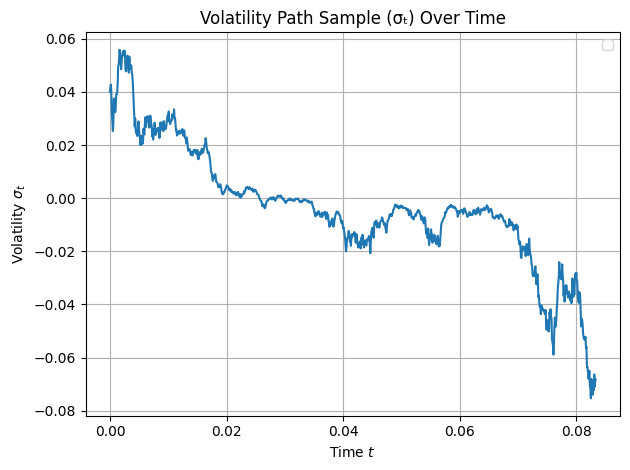

In [255]:
rho = -0.5
lamda_x = 0.5
lamda_y = 0.6
n_steps = 1000
N_sim = 1000
n_steps = 1000     # for example
T = 1/12            # maturity
N_sims = 5000      # number of paths
theta= 0.65
S_0 = 100
dt = T / n_steps

# 1D time grid for one path (size: n_steps)
tt_1d = np.linspace(0, T, n_steps+1)
w1 = np.random.normal(0, 1, (n_steps, N_sims))
a_k = np.array([0.0004, 0.0038, 0.0004, 0.0085, 0.0005, 1])
# Broadcast to shape (n_steps, N_sims)
tt = np.tile(tt_1d.reshape(-1, 1), (1, N_sims))
_, x1 = simulate_OU(lamda_x,T,n_steps=n_steps,N_sims=N_sims,w=w1)
_, x2 = simulate_OU(lamda_x,T,n_steps=n_steps,N_sims=N_sims,w=w1)
print(x1.shape)
print(x2.shape)
X_t = theta * x1 +(1-theta) * x2
std_X_t = std_X_t(theta, lamda_x,lamda_y,tt)
volatility = volatility(std_X_t,X_t,a_k,T_nodes,int_var_nodes,tt)
S_T = simulate_log_S_t(S_0, rho, volatility, dt, w1)
strikes = np.linspace(80, 120, 10)
plt.plot(tt_1d,volatility[:,0])
plt.title('Volatility Path Sample (σₜ) Over Time')
plt.xlabel('Time $t$')
plt.ylabel('Volatility $\\sigma_t$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


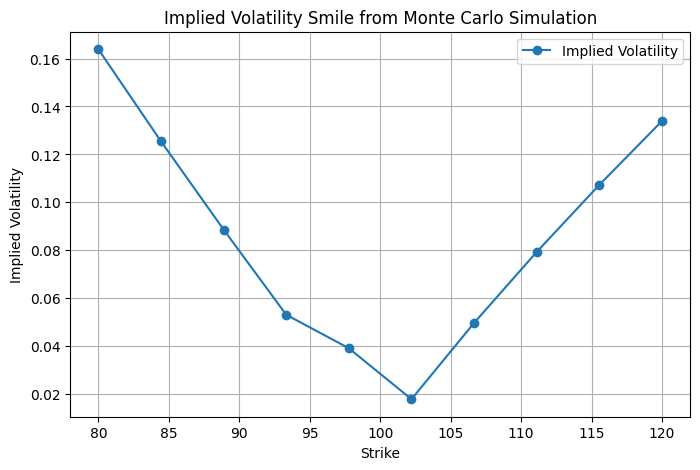

In [256]:
import numpy as np
import matplotlib.pyplot as plt
from py_vollib.black_scholes.implied_volatility import implied_volatility

# Inputs: S_0 (scalar), S_T (N_sims,), strikes (n_strikes,), T (scalar)
# Example: S_0 = 100, T = 1/12

# 1. Compute Monte Carlo prices
call_prices = np.maximum(S_T[:, None] - strikes[None, :], 0)  # shape (N_sims, n_strikes)
call_mean = np.mean(call_prices, axis=0)                      # shape (n_strikes,)
epsilon = 1e-6
intrinsic = np.maximum(S_0 - strikes, 0)
call_mean = np.maximum(call_mean, intrinsic + epsilon)
# 2. Compute implied volatilities
def vec_find_iv_rat(opt_price, S, K, t, r, flag):
    return np.vectorize(implied_volatility)(opt_price, S, K, t, r, flag)

ivs = vec_find_iv_rat(call_mean, S_0, strikes, T, 0.0, 'c')

# 3. Plot the implied volatility smile
plt.figure(figsize=(8, 5))
plt.plot(strikes, ivs, marker='o', label='Implied Volatility')
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Smile from Monte Carlo Simulation")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
def compute_quadrature_T_to_Tdelta(T, delt=30/360, n_points=20):
    """
    Calcule les points et poids de quadrature de Gauss–Legendre transformés
    sur l’intervalle [T, T + delt].

    Paramètres :
    -----------
    T : float
        Maturité (début de l’intervalle)
    delt : float, optionnel
        Longueur de l’intervalle (par défaut 30/360)
    n_points : int, optionnel
        Nombre de points de quadrature (par défaut 20)

    Retour :
    --------
    tt : ndarray
        Points de quadrature sur [T, T + delt]
    w_tt : ndarray
        Poids correspondants
    """
    # Quadrature standard sur [-1, 1]
    tt_gs, w_t_gs = np.polynomial.legendre.leggauss(n_points)
    
    # Changement de variable vers [T, T + delt]
    tt = 0.5 * (tt_gs + 1) * delt + T
    w_tt = 0.5 * delt * w_t_gs
    
    return tt, w_tt

def compute_fv_curve(tt, T_nodes, int_var_nodes):
    """
    Évalue la dérivée de la courbe d’intégrale de variance sur les points tt.

    Paramètres :
    -----------
    tt : ndarray
        Points de quadrature (temps) où évaluer ξ₀(t)
    T_nodes : ndarray
        Grille de temps utilisée pour interpoler IntVar(t)
    int_var_nodes : ndarray
        Valeurs de l’intégrale de variance aux points T_nodes

    Retour :
    --------
    fv_curve : ndarray
        ξ₀(t) = d/dt IntVar(t), forcé à être positif (sqrt du carré)
    """
    spline = interpolate.splrep(T_nodes, int_var_nodes, k=3)
    d_intvar = interpolate.splev(tt, spline, der=1)
    fv_curve = np.sqrt(d_intvar**2)  # pour s’assurer que ξ₀(t) ≥ 0
    return fv_curve
import numpy as np
from scipy.special import factorial2

def compute_normalization(std_Z_t, p_k):
    """
    Calcule le facteur de normalisation E[f(Z_t)^2] pour un polynôme f 
    sur un processus gaussien de variance std_Z_t^2.

    Paramètres :
    -----------
    std_Z_t : ndarray de forme (n_points,)
        Écarts-types du processus Z_t en chaque temps t
    p_k : ndarray
        Coefficients du polynôme f (degré d)

    Retour :
    --------
    normal_cst : ndarray
        Valeur de E[f(Z_t)^2] pour chaque temps t (même taille que std_Z_t)
    """
    n = len(p_k)
    cauchy_product = np.convolve(p_k, p_k)  # produit de Cauchy des coefficients
    even_indices = np.arange(0, 2 * n, 2).reshape(-1, 1)  # k pairs : 0,2,...,2n−2

    std_powers = std_Z_t[np.newaxis, :] ** even_indices  # std^k
    double_fac = np.maximum(factorial2(even_indices - 1), 1)

    normal_var = np.sum(
        cauchy_product[even_indices] * std_powers * double_fac,
        axis=0
    )
    return normal_var
import numpy as np
from scipy.special import factorial2

def compute_gaussian_moments(std_array, max_deg):
    """
    Calcule les moments E[G^k] pour G ~ N(0, std^2), pour k = 0, ..., max_deg−1

    Paramètres :
    -----------
    std_array : ndarray de forme (n,)
        Valeurs de σ (écart-type) pour chaque t
    max_deg : int
        Nombre de moments à calculer (k = 0, ..., max_deg−1)

    Retour :
    --------
    moments : ndarray de forme (max_deg, n)
        moments[k, i] = E[G_i^k]
    """
    k_array = np.arange(max_deg).reshape(-1, 1)  # forme (k,1)
    std_powers = std_array[np.newaxis, :] ** k_array  # σ^k

    # double factorielle pour k pairs, 0 pour k impairs
    even_mask = (k_array % 2 == 0)
    double_fac = factorial2(k_array - 1)
    double_fac = np.where(even_mask, double_fac, 0)

    moments = std_powers * double_fac
    return moments
import numpy as np

def simulate_X_Y(Z_mc, var_X_t, var_Y_t, cov_XY_t):
    """
    Simule des variables gaussiennes X_T et Y_T corrélées à partir de Z_mc.

    Paramètres :
    -----------
    Z_mc : ndarray shape (2, N)
        Deux vecteurs de gaussiennes standard indépendantes
    var_X_t : float
        Variance de X_T
    var_Y_t : float
        Variance de Y_T
    cov_XY_t : float
        Covariance entre X_T et Y_T

    Retour :
    --------
    X : ndarray shape (N,)
        Simulations de X_T
    Y : ndarray shape (N,)
        Simulations de Y_T
    """
    rho = cov_XY_t / np.sqrt(var_X_t * var_Y_t)
    rho = np.clip(rho, -1.0, 1.0)  # sécurité numérique

    Z1 = Z_mc[0]
    Z2 = Z_mc[1]

    X = np.sqrt(var_X_t) * Z1
    Y = np.sqrt(var_Y_t) * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)

    return X, Y
import numpy as np

def compute_powers(X, Y, max_deg):
    """
    Calcule les puissances X^k et Y^k pour k = 0, ..., max_deg - 1

    Paramètres :
    -----------
    X : ndarray shape (N,)
        Vecteur de simulations de X_T
    Y : ndarray shape (N,)
        Vecteur de simulations de Y_T
    max_deg : int
        Degré maximal à évaluer

    Retour :
    --------
    X_power : ndarray shape (max_deg, N)
        Puissances X^k pour tous les k
    Y_power : ndarray shape (max_deg, N)
        Puissances Y^k pour tous les k
    """
    N = len(X)
    exponents = np.arange(max_deg).reshape(-1, 1)
    
    X_power = X[np.newaxis, :] ** exponents  # shape (max_deg, N)
    Y_power = Y[np.newaxis, :] ** exponents

    return X_power, Y_power


import numpy as np
from scipy.special import comb

def compute_beta_matrix(cauchy_product, mmt_G_s_t, w_tt, tt, theta, lambda_x, lambda_y, g0_squared):
    """
    Calcule les coefficients β_{m,l} pour un polynôme f(x), via quadrature.

    Paramètres :
    -----------
    cauchy_product : ndarray shape (2n - 1,)
        Produit de Cauchy des coefficients du polynôme
    mmt_G_s_t : ndarray shape (2n - 1, n_points)
        Moments de G_s^t pour chaque ordre et chaque point de quadrature
    w_tt : ndarray shape (n_points,)
        Poids de quadrature sur [T, T+Δ]
    tt : ndarray shape (n_points,)
        Points de quadrature t ∈ [T, T+Δ]
    theta : float
        Pondération entre les deux facteurs OU
    lambda_x : float
        Paramètre de décroissance du facteur X
    lambda_y : float
        Paramètre de décroissance du facteur Y
    g0_squared : ndarray shape (n_points,)
        Valeurs de g₀²(t) pour chaque t

    Retour :
    --------
    beta_m_l : ndarray shape (2n - 1, 2n - 1)
        Matrice triangulaire supérieure des coefficients β_{m,l}
    """
    d = len(cauchy_product)
    beta_m_l = np.zeros((d, d))
    combinatory_matrix = comb(np.arange(d).reshape(-1, 1), np.arange(d))  # binomial(m, l)

    for m in range(d):
        for l in range(m, d):
            decay = np.exp(-(m * lambda_x + (l - m) * lambda_y) * (tt - tt[0]))  # t − T
            k_range = np.arange(l, d)
            integrand = mmt_G_s_t[k_range - l] * decay * g0_squared  # shape (len(k_range), n_points)
            integral = np.sum(integrand * w_tt, axis=1)  # intégration sur t
            beta = cauchy_product[k_range] * integral
            binom_part = comb(l, m) * comb(k_range, l) * (1 - theta) ** (l - m) * theta ** m
            beta_m_l[m, l] = np.sum(beta * binom_part)

    return beta_m_l
import numpy as np

def compute_vix_T_squared(X_power, Y_power, beta_m_l, delta):
    """
    Calcule les valeurs simulées de VIX_T^2 = 1/Δ ∑_{m≤l} β_{m,l} X^m Y^{l−m}

    Paramètres :
    -----------
    X_power : ndarray shape (d, N)
        Puissances de X : X^0, X^1, ..., X^{d−1}
    Y_power : ndarray shape (d, N)
        Puissances de Y : Y^0, ..., Y^{d−1}
    beta_m_l : ndarray shape (d, d)
        Matrice triangulaire supérieure des β_{m,l}
    delta : float
        Fenêtre de moyenne pour la VIX (30/360 en général)

    Retour :
    --------
    vix_squared : ndarray shape (N,)
        Valeurs simulées de VIX_T^2
    """
    d, N = X_power.shape
    vix_squared = np.zeros(N)

    for m in range(d):
        for l in range(m, d):
            vix_squared += beta_m_l[m, l] * X_power[m] * Y_power[l - m]

    vix_squared /= delta
    vix_squared = np.maximum(vix_squared, 1e-10)

    return vix_squared
import numpy as np

def compute_option_price(vix_T, strike_perc):
    """
    Calcule le prix moyen d’un call sur VIX et son écart-type.

    Paramètres :
    -----------
    vix_T : ndarray shape (N,)
        Simulations de VIX_T
    strike_perc : float
        Strike exprimé en pourcentage du forward VIX (e.g. 0.9, 1.0, 1.1)

    Retour :
    --------
    Ft : float
        Forward VIX = moyenne de VIX_T
    vix_strike : float
        Strike K = strike_perc × Ft
    vix_call_price : float
        Prix moyen du call
    vix_call_std : float
        Écart-type du call
    vix_call_payoff : ndarray
        Valeurs simulées de (VIX_T - K)^+
    """
    Ft = np.mean(vix_T)
    K = strike_perc * Ft
    vix_call_payoff = np.maximum(vix_T - K, 0)

    price = np.mean(vix_call_payoff)
    std = np.std(vix_call_payoff)

    return Ft, K, price, std, vix_call_payoff
def compute_implied_vol(vix_call_price, vix_call_std, Ft, K_array, T, bs_iv_func):
    """
    Calcule la volatilité implicite à partir du prix de l’option sur la VIX.

    Paramètres :
    -----------
    vix_call_price : ndarray
        Prix moyen du call simulé
    vix_call_std : ndarray
        Écart-type du prix simulé
    Ft : float
        Forward VIX
    K_array : ndarray
        Strikes considérés
    T : float
        Maturité de l’option
    bs_iv_func : fonction
        Fonction d’inversion Black-Scholes : sigma = bs_iv_func(price, F, K, T, r, flag)

    Retour :
    --------
    vix_iv : ndarray
        Volatilité implicite
    vix_iv_u : ndarray
        Borne supérieure (IC 95%)
    vix_iv_l : ndarray
        Borne inférieure (IC 95%)
    """
    N = len(vix_call_price)
    r = 0.0
    flag = 'c'

    # IC à 95%
    std_error = vix_call_std / np.sqrt(N)
    upper = vix_call_price + 1.96 * std_error
    lower = np.maximum(vix_call_price - 1.96 * std_error, 1e-8)

    vix_iv = bs_iv_func(vix_call_price, Ft, K_array, T, r, flag)
    vix_iv_u = bs_iv_func(upper, Ft, K_array, T, r, flag)
    vix_iv_l = bs_iv_func(lower, Ft, K_array, T, r, flag)

    return vix_iv, vix_iv_u, vix_iv_l
import matplotlib.pyplot as plt

def generate_iv_curve(
    T, p_k, theta, lamda_x, lamda_y, T_nodes, int_var_nodes,
    Z_mc, strike_perc_array, bs_iv_func, delta=30/360
):
    # Étapes 1-2
    tt, w_tt = compute_quadrature_T_to_Tdelta(T, delt=delta)
    fv_curve = compute_fv_curve(tt, T_nodes, int_var_nodes)

    # Étape 3
    std_Z_t = np.sqrt(
        theta**2 / (2 * lamda_x) * (1 - np.exp(-2 * lamda_x * tt)) +
        (1 - theta)**2 / (2 * lamda_y) * (1 - np.exp(-2 * lamda_y * tt)) +
        2 * theta * (1 - theta) / (lamda_x + lamda_y) * (1 - np.exp(-(lamda_x + lamda_y) * tt))
    )
    normal_cst = compute_normalization(std_Z_t, p_k)
    g0_squared = fv_curve / normal_cst

    # Étape 4
    std_G_s_t = np.sqrt(
        theta**2 / (2 * lamda_x) * (1 - np.exp(-2 * lamda_x * (tt - T))) +
        (1 - theta)**2 / (2 * lamda_y) * (1 - np.exp(-2 * lamda_y * (tt - T))) +
        2 * theta * (1 - theta) / (lamda_x + lamda_y) * (1 - np.exp(-(lamda_x + lamda_y) * (tt - T)))
    )
    d = 2 * len(p_k) - 1
    mmt_G_s_t = compute_gaussian_moments(std_G_s_t, d)

    # Étape 5
    var_X_t = theta**2 / (2 * lamda_x) * (1 - np.exp(-2 * lamda_x * T))
    var_Y_t = (1 - theta)**2 / (2 * lamda_y) * (1 - np.exp(-2 * lamda_y * T))
    cov_XY_t = theta * (1 - theta) / (lamda_x + lamda_y) * (1 - np.exp(-(lamda_x + lamda_y) * T))
    X, Y = simulate_X_Y(Z_mc, var_X_t, var_Y_t, cov_XY_t)

    # Étape 6
    X_power, Y_power = compute_powers(X, Y, d)

    # Étape 7
    cauchy_product = np.convolve(p_k, p_k)
    beta_m_l = compute_beta_matrix(cauchy_product, mmt_G_s_t, w_tt, tt, theta, lamda_x, lamda_y, g0_squared)

    # Étape 8
    vix_T_squared = compute_vix_T_squared(X_power, Y_power, beta_m_l, delta)
    vix_T = np.sqrt(vix_T_squared)

    # Boucle sur les strikes
    iv_list, iv_u_list, iv_l_list, strikes = [], [], [], []

    for strike_perc in strike_perc_array:
        Ft, K, price, std, _ = compute_option_price(vix_T, strike_perc)
        iv, iv_u, iv_l = compute_implied_vol(np.array([price]), np.array([std]), Ft, np.array([K]), T, bs_iv_func)
        iv_list.append(iv[0])
        iv_u_list.append(iv_u[0])
        iv_l_list.append(iv_l[0])
        strikes.append(K)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(strikes, iv_list, label='Implied Volatility')
    plt.fill_between(strikes, iv_l_list, iv_u_list, alpha=0.2, label='95% CI')
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.title('VIX Call Implied Volatility Curve')
    plt.grid(True)
    plt.legend()
    plt.show()
